# Libraries

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
from skimage import io
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
import skimage
from sklearn import preprocessing
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import random

# GLCM Features

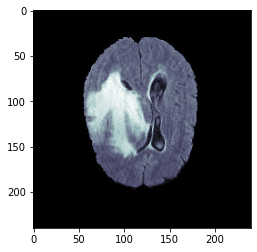

(240, 240)

In [ ]:
plt.imshow(image, cmap="bone")
plt.show()
image.shape

C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` in

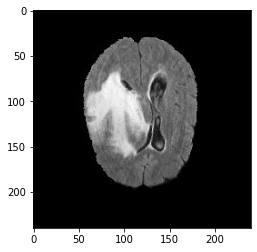

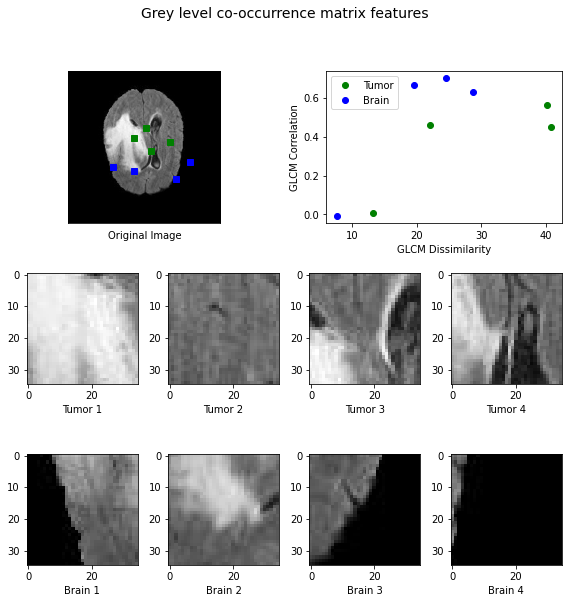

In [ ]:
PATCH_SIZE = 35

image = cv2.imread(r'D:\FYP_Code\JPG_Dataset\Training\flair\yes\y (1).jpg')
plt.imshow(image, cmap='gray')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Full image
GLCM = greycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
a= greycoprops(GLCM, 'energy')[0, 0]

# selecting some patches from white areas of the brain in image
tumor_locations = [(87, 85), (93, 143), (71, 104), (107, 113)]
tumor_patches = []
for loc in tumor_locations:
    tumor_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from sky areas of the image
brain_locations = [(133, 53), (139, 85), (152, 152), (125, 174)]
brain_patches = []
for loc in brain_locations:
    brain_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
diss_sim = []
corr = []
homogen = []
energy = []
contrast = []
for patch in (tumor_patches + brain_patches):
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    diss_sim.append(greycoprops(glcm, 'dissimilarity')[0, 0]) #[0,0] to convert array to value
    corr.append(greycoprops(glcm, 'correlation')[0, 0])
    homogen.append(greycoprops(glcm, 'homogeneity')[0, 0])
    energy.append(greycoprops(glcm, 'energy')[0, 0])
    contrast.append(greycoprops(glcm, 'contrast')[0, 0])


# OPTIONAL PLOTTING for Visualization of points and patches
# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in tumor_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in brain_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(diss_sim[:len(tumor_patches)], corr[:len(tumor_patches)], 'go',
        label='Tumor')
ax.plot(diss_sim[len(brain_patches):], corr[len(brain_patches):], 'bo',
        label='Brain')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(tumor_patches):
    ax = fig.add_subplot(3, len(tumor_patches), len(tumor_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Tumor %d' % (i + 1))

for i, patch in enumerate(brain_patches):
    ax = fig.add_subplot(3, len(brain_patches), len(brain_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Brain %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

# GLCM Classification

## Reading Images

In [ ]:
def read_dataset(dataset_dir, SIZE, images, labels):
    for folder in os.listdir(dataset_dir):
        folder_files = os.listdir(os.path.join(dataset_dir, folder))
        len_folder = len(folder_files) - 1
        for i, filename in enumerate(folder_files):
            img = cv2.imread(os.path.join(dataset_dir, folder, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (SIZE, SIZE))

            images.append(img)
            labels.append(str(folder))
    
    
dataset_dir = r"D:\FYP_Code\JPG_Dataset\Training\flair"
train_images = []
train_labels = []
read_dataset(dataset_dir, 128, train_images, train_labels)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

dataset_dir = r"D:\FYP_Code\JPG_Dataset\Validation\flair"
test_images = []
test_labels = []
read_dataset(dataset_dir, 128, test_images, test_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
#Encode labels from text (folder names) to integers.
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Normalize pixel values to between 0 and 1
x_train, x_test = (x_train//255), (x_test//255)

###################################################################
# FEATURE EXTRACTOR function
# input shape is (n, x, y, c) - number of images, x, y, and channels
def feature_extractor(dataset):
    image_dataset = pd.DataFrame()
    for image in range(dataset.shape[0]):  #iterate through each file 
        #print(image)
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        img = dataset[image, :,:]
    ################################################################
    #START ADDING DATA TO THE DATAFRAME
  
                
         #Full image
        #GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        GLCM = greycomatrix(img, [1], [0])       
        GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        df['Energy'] = GLCM_Energy
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        df['Corr'] = GLCM_corr       
        GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
        df['Diss_sim'] = GLCM_diss       
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        df['Homogen'] = GLCM_hom       
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]
        df['Contrast'] = GLCM_contr


        GLCM2 = greycomatrix(img, [3], [0])       
        GLCM_Energy2 = greycoprops(GLCM2, 'energy')[0]
        df['Energy2'] = GLCM_Energy2
        GLCM_corr2 = greycoprops(GLCM2, 'correlation')[0]
        df['Corr2'] = GLCM_corr2       
        GLCM_diss2 = greycoprops(GLCM2, 'dissimilarity')[0]
        df['Diss_sim2'] = GLCM_diss2       
        GLCM_hom2 = greycoprops(GLCM2, 'homogeneity')[0]
        df['Homogen2'] = GLCM_hom2       
        GLCM_contr2 = greycoprops(GLCM2, 'contrast')[0]
        df['Contrast2'] = GLCM_contr2

        GLCM3 = greycomatrix(img, [5], [0])       
        GLCM_Energy3 = greycoprops(GLCM3, 'energy')[0]
        df['Energy3'] = GLCM_Energy3
        GLCM_corr3 = greycoprops(GLCM3, 'correlation')[0]
        df['Corr3'] = GLCM_corr3       
        GLCM_diss3 = greycoprops(GLCM3, 'dissimilarity')[0]
        df['Diss_sim3'] = GLCM_diss3       
        GLCM_hom3 = greycoprops(GLCM3, 'homogeneity')[0]
        df['Homogen3'] = GLCM_hom3       
        GLCM_contr3 = greycoprops(GLCM3, 'contrast')[0]
        df['Contrast3'] = GLCM_contr3

        GLCM4 = greycomatrix(img, [0], [np.pi/4])       
        GLCM_Energy4 = greycoprops(GLCM4, 'energy')[0]
        df['Energy4'] = GLCM_Energy4
        GLCM_corr4 = greycoprops(GLCM4, 'correlation')[0]
        df['Corr4'] = GLCM_corr4       
        GLCM_diss4 = greycoprops(GLCM4, 'dissimilarity')[0]
        df['Diss_sim4'] = GLCM_diss4       
        GLCM_hom4 = greycoprops(GLCM4, 'homogeneity')[0]
        df['Homogen4'] = GLCM_hom4       
        GLCM_contr4 = greycoprops(GLCM4, 'contrast')[0]
        df['Contrast4'] = GLCM_contr4
        
        GLCM5 = greycomatrix(img, [0], [np.pi/2])       
        GLCM_Energy5 = greycoprops(GLCM5, 'energy')[0]
        df['Energy5'] = GLCM_Energy5
        GLCM_corr5 = greycoprops(GLCM5, 'correlation')[0]
        df['Corr5'] = GLCM_corr5       
        GLCM_diss5 = greycoprops(GLCM5, 'dissimilarity')[0]
        df['Diss_sim5'] = GLCM_diss5       
        GLCM_hom5 = greycoprops(GLCM5, 'homogeneity')[0]
        df['Homogen5'] = GLCM_hom5       
        GLCM_contr5 = greycoprops(GLCM5, 'contrast')[0]
        df['Contrast5'] = GLCM_contr5
        
        #Add more filters as needed
        #entropy = shannon_entropy(img)
        #df['Entropy'] = entropy

        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset

In [ ]:
#Extract features from training images
image_features = feature_extractor(x_train)
X_for_ML =image_features

C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` inst

In [ ]:
#Reshape to a vector for Random Forest / SVM training
#n_features = image_features.shape[1]
#image_features = np.expand_dims(image_features, axis=0)
#X_for_ML = np.reshape(image_features, (x_train.shape[0], -1))  #Reshape to #images, features

#Define the classifier
# from sklearn.ensemble import RandomForestClassifier
# RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

#Can also use SVM but RF is faster and may be more accurate.
#from sklearn import svm
#SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
#SVM_model.fit(X_for_ML, y_train)

# Fit the model on training data
# RF_model.fit(X_for_ML, y_train) #For sklearn no one hot encoding

In [ ]:
#Class names for LGBM start at 0 so reassigning labels from 1,2,3,4 to 0,1,2,3
d_train = lgb.Dataset(X_for_ML, label=y_train)

# https://lightgbm.readthedocs.io/en/latest/Parameters.html
lgbm_params = {'learning_rate':0.05, 'boosting_type':'dart',    
              'objective':'multiclass',
              'metric': 'multi_logloss',
              'num_leaves':100,
              'max_depth':10,
              'num_class':4}  #no.of unique values in the target class not inclusive of the end value


lgb_model = lgb.train(lgbm_params, d_train, 100) #50 iterations. Increase iterations for small learning rates

In [ ]:
#Predict on Test data
#Extract features from test data and reshape, just like training data
test_features = feature_extractor(x_test)
test_features = np.expand_dims(test_features, axis=0)
test_for_RF = np.reshape(test_features, (x_test.shape[0], -1))

#Predict on test
test_prediction = lgb_model.predict(test_for_RF)
test_prediction=np.argmax(test_prediction, axis=1)
#Inverse le transform to get original label back. 
test_prediction = le.inverse_transform(test_prediction)

Accuracy =  0.872


<AxesSubplot:>

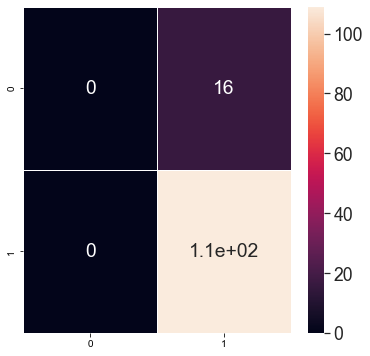

In [ ]:
#Print overall accuracy
print ("Accuracy = ", metrics.accuracy_score(test_labels, test_prediction))

#Print confusion matrix
cm = confusion_matrix(test_labels, test_prediction)

fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` inst

The prediction for this image is:  ['yes']
The actual label for this image is:  yes


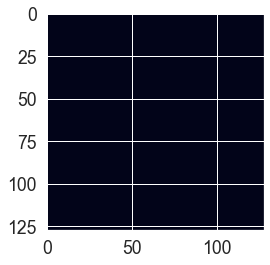

In [ ]:
#Check results on a few random images
n=random.randint(0, x_test.shape[0]-1) #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)

#Extract features and reshape to right dimensions
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor(input_img)
input_img_features = np.expand_dims(input_img_features, axis=0)
input_img_for_RF = np.reshape(input_img_features, (input_img.shape[0], -1))
#Predict
img_prediction = lgb_model.predict(input_img_for_RF)
img_prediction=np.argmax(img_prediction, axis=1)
img_prediction = le.inverse_transform([img_prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", img_prediction)
print("The actual label for this image is: ", test_labels[n])